In [1]:
import importlib
import numpy as np

import Parallel_Run
importlib.reload(Parallel_Run)

import matplotlib.pyplot as plt

Ec = lambda L,N : 3/2*np.log(L/N* np.pi/3)


In [34]:
# gillespie parameter
Nlinker = 20
ell_tot = 10**3
kdiff = 1.
Energy = -15

Nprocess = 30
args = [[ell_tot,Energy,kdiff,np.random.randint(1000000),Nlinker,3] for _ in range(Nprocess)]

# argument of the different classes
cluster_arg = tuple([3.]) # max distance
MSD_arg = () # no argument 
ISF_arg = (0.1,10) # q_norm, q_num_sample
NRG_arg = ()
PCF_arg = (np.sqrt(ell_tot),30) # max_distance,numb_bin

# Simulation parameters
step_tot = 10**4
check_steps = 10**3
coarse_grained_step = 10**1

In [35]:
#args, step_tot, check_steps,coarse_grained_step,filename,cluster_arg,MSD_arg,ISF_arg,NRG_arg,PCF_arg
Parallel_Run.parallel_evolution(args,step_tot,check_steps,coarse_grained_step,'Test.hdf',
                                cluster_arg,MSD_arg,ISF_arg,NRG_arg,PCF_arg)

In [36]:
import Reader
importlib.reload(Reader)
from Reader import CustomHDF5Reader

In [58]:
class Data_Treatement:
    def __init__(self,filename,data_type):
        self.Read = CustomHDF5Reader(filename)
        self.Read.open()
        self.attributes = self.Read.get_header_attributes()
        #print(self.Read.list_measurements(self.Read.list_groups()[0]))
        if data_type not in self.Read.list_measurements(self.Read.list_groups()[0]):
            raise ValueError('data_type unknown')
        else:
            # data shape :
            # if the data is a scalar: data.shape = (Nsample,step_tot//coarse_steps)
            # if it is a function: data.shape = (Nsample,step_tot//check_steps,check_steps//coarse_stetps)
            self.data = np.array([self.Read.get_measurement_data(grp,data_type) for grp in self.Read.list_groups()])
        if self.data[0].shape == self.Read.get_measurement_data(self.Read.list_groups()[0],"Check_Time").shape:
            TimeType = "Check_Time"
        elif self.data[0].shape == self.Read.get_measurement_data(self.Read.list_groups()[0],"Coarse_Time").shape:
            TimeType = "Coarse_Time"
        else:
            print(self.data[0].shape)
            print(self.Read.get_measurement_data(self.Read.list_groups()[0],"Coarse_Time").shape)
            print(self.Read.get_measurement_data(self.Read.list_groups()[0],"Check_Time").shape)
            raise ValueError('No time with correct shape found')
        self.time = np.array([self.Read.get_measurement_data(grp,TimeType) for grp in self.Read.list_groups()])
        self.Nsample = len(self.Read.list_groups())
        self.Read.close()
    def average(self,num_bins=100):
        if len(self.time.shape)==2: # which mean average a scalar:
            self.binned_time,self.average_data,self.variance = average_scalar(self.time,self.data,num_bins)
        elif len(self.time.shape)==3: # for MSD and ISF for instance
            self.binned_time,self.average_data,self.variance = np.zeros((self.data.shape[1],num_bins),dtype=float),np.zeros((self.data.shape[1],num_bins),dtype=float),np.zeros((self.data.shape[1],num_bins),dtype=float)
            for index in range(self.data.shape[1]):
                self.binned_time[index],self.average_data[index],self.variance[index] = average_scalar(self.time[:,index],self.data[:,index])
        else:
            raise IndexError('Invalid time shape')
    
def average_scalar(X, Y, num_bins=100):
    bins = np.linspace(X.min(), X.max(), num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    average_scalar = np.zeros(num_bins)
    variance_scalar = np.zeros(num_bins) + np.nan  # Initialize with NaN
    
    for i in range(num_bins):
        scalar_values = []
        for j in range(Y.shape[0]):
            indices = np.digitize(X[j], bins) - 1
            indices = np.clip(indices, 0, num_bins-1)
            within_bin = Y[j][indices == i]
            if within_bin.size > 0:
                scalar_values.extend(within_bin)
        if scalar_values:
            average_scalar[i] = np.mean(scalar_values)
            if len(scalar_values) > 1:  # Ensure at least two data points for variance
                variance_scalar[i] = np.var(scalar_values, ddof=1)
            else:
                variance_scalar[i] = 0  # Or set to 0, if that's more appropriate for your analysis
            
    return bin_centers, average_scalar, variance_scalar
    #bins = np.linspace(X.min(), X.max(), num_bins + 1)
    #bin_centers = (bins[:-1] + bins[1:]) / 2
    #average_scalar = np.zeros(num_bins)
    #variance_scalar = np.zeros(num_bins)
#
    #for i in range(num_bins):
    #    scalar_values = [][0]
    #    for j in range(Y.shape[0]):
    #        indices = np.digitize(X[j], bins) - 1  # Calculate bin indices
    #        indices = np.clip(indices, 0, num_bins-1)  # Ensure indices are within valid range
    #        within_bin = Y[j][indices == i]  # Select values within the current bin
    #        if within_bin.size > 0:
    #            scalar_values.extend(within_bin)
    #    if scalar_values:
    #        average_scalar[i] = np.mean(scalar_values)
    #        variance_scalar[i] = np.var(scalar_values, ddof=1)  # ddof=1 for sample variance
    #        
    #return bin_centers, average_scalar,variance_scalar

In [59]:
Read = CustomHDF5Reader('Test.hdf')
Read.open()
attributes = Read.get_header_attributes()
for key,value in attributes.items():
    print(key + '  '+str(value))
#print(Read.list_groups())
#print(Read.list_measurements( Read.list_groups()[0]))
#print(Read.get_measurement_data(Read.list_groups()[0],'Check_Time'))
Read.close()

ell_tot  1000
Energy  -15
kdiff  1.0
seed  788168
Nlinker  20
dimension  3
step_tot  10000
check_steps  1000
coarse_grained_step  10
cluster_max_distance  (3.0,)
MSD_args  ()
ISF_q_norm  (0.1, 10)
ISF_q_num_sample  ()
NRG_args  (31.622776601683793, 30)


In [60]:
data = Data_Treatement('Test.hdf',"MSD")
print(data.time.shape)
data2 = Data_Treatement('Test.hdf',"NRG")
print(len(data2.time.shape))

(30, 10, 100)
2


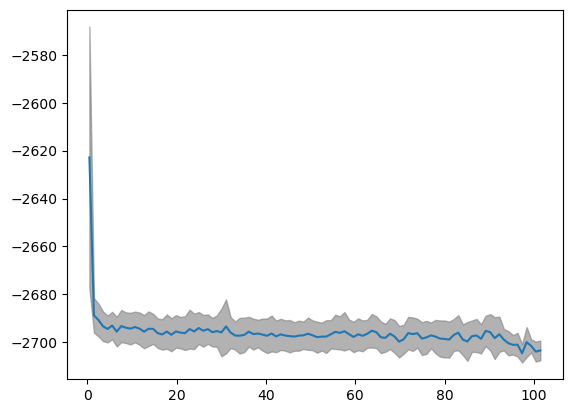

In [66]:
data2.average()
data2.average_data.shape

#for i in range(data2.Nsample):
 #    #for j in range(-1):#data.time[i].shape[0]):
#     plt.plot((data2.time[i]),data2.data[i],color='black',alpha=0.3)
plt.plot(data2.binned_time,data2.average_data)
plt.fill_between(data2.binned_time, data2.average_data-np.sqrt(data2.variance), data2.average_data+np.sqrt(data2.variance), color='gray', alpha=0.6)
#plt.xscale('log')